In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pymap3d as pm
from scipy.spatial.transform import Rotation
import math
from pathlib import Path
from utils import project_root

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

# Extrinsic calibrations and globals

In [3]:
# seq: {‘X’, ‘Y’, ‘Z’} for intrinsic rotations, or {‘x’, ‘y’, ‘z’} for extrinsic rotations
# Wikipedia: The three elemental rotations may be extrinsic (rotations about the axes xyz 
# of the original coordinate system, which is assumed to remain motionless), or intrinsic 
# (rotations about the axes of the rotating coordinate system XYZ, 
# solidary with the moving body, which changes its orientation after each elemental rotation).
rot_order = 'xyz'

In [4]:
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]

In [5]:
R_b2i = Rotation.from_euler('z', 1.5708, degrees=False).as_matrix()
R_b2i

array([[-3.6732051e-06, -1.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00, -3.6732051e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [6]:
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]

In [7]:
# GPS translational offset
gps_off = np.array([-0.01, 0, 2.13]).reshape((3,1))

In [8]:
GRAV = -9.80665

# Covariances

In [9]:
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]

In [10]:
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]

In [11]:
var_p = 0.019599999999999996
sigma_p = np.sqrt(var_p)
var_a = 0.01
sigma_a = np.sqrt(var_a)
var_w = 0.0006
sigma_w = np.sqrt(var_w)

# Helper functions

In [12]:
# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

# Load data

In [13]:
os.chdir(Path(project_root() / 'data/topics'))

## IMU data (orientation, ang_vel, lin_acc) - "/ouster/imu"

### Load IMU data

In [14]:
lines = []
with open('imu.txt') as f:
    lines = f.readlines()

In [15]:
ang_vel = [] # [w_x, w_y, w_z]
ang_vel_e = []
lin_acc = [] # [x_ddot, y_ddot, z_ddot]
sec_imu = []
nsec_imu = []
count = 0

for idx, line in enumerate(lines):
    count += 1
    if line[4:7] == "sec":
        sec_imu.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_imu.append(int(line[13:-1]))
    elif line[0:-1] == "orientation:":
        qx = float(lines[idx+1][5:-1])
        qy = float(lines[idx+2][5:-1])
        qz = float(lines[idx+3][5:-1])
        qw = float(lines[idx+4][5:-1])
        q = [qx, qy, qz, qw]
    elif line[0:-1] == "angular_velocity:":
        w_x = float(lines[idx+1][5:-1])
        w_y = float(lines[idx+2][5:-1])
        w_z = float(lines[idx+3][5:-1])
        ang_vel.append([w_x, w_y, w_z])
        ang_vel_e.append([np.rad2deg(w_x), np.rad2deg(w_y), np.rad2deg(w_z)])
    elif line[0:-1] == "linear_acceleration:":
        a_x = float(lines[idx+1][5:-1])
        a_y = float(lines[idx+2][5:-1])
        a_z = float(lines[idx+3][5:-1])
        lin_acc.append([a_x, a_y, a_z])

ang_vel = np.array(ang_vel)
ang_vel_e = np.array(ang_vel_e)
lin_acc = np.array(lin_acc)

In [16]:
temp = [i*1e-9 for i in nsec_imu]
t_imu = [sum(x) for x in zip(sec_imu, temp)]
tt_imu = [x-t_imu[0] for x in t_imu]

### Find IMU bias

In [17]:
m = 300
t = np.arange(m)

[-0.01907755  0.01299578 -0.00510084]


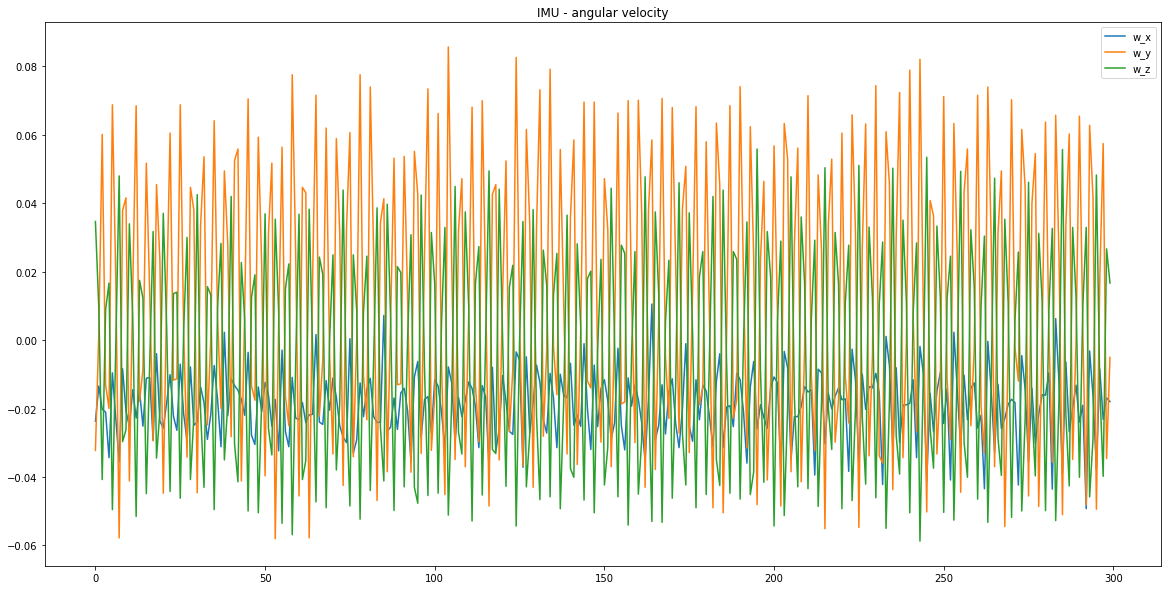

In [18]:
static_ang_vel = np.array(ang_vel)[0:m,:]
ang_vel_imu_bias = np.mean(static_ang_vel, axis=0)
print(ang_vel_imu_bias)

plt.plot(t, ang_vel[0:m,0], label="w_x")
plt.plot(t, ang_vel[0:m,1], label="w_y")
plt.plot(t, ang_vel[0:m,2], label="w_z")
plt.title("IMU - angular velocity")
plt.legend()
plt.show()

[ 0.10895214 -0.80556905  9.71302873]


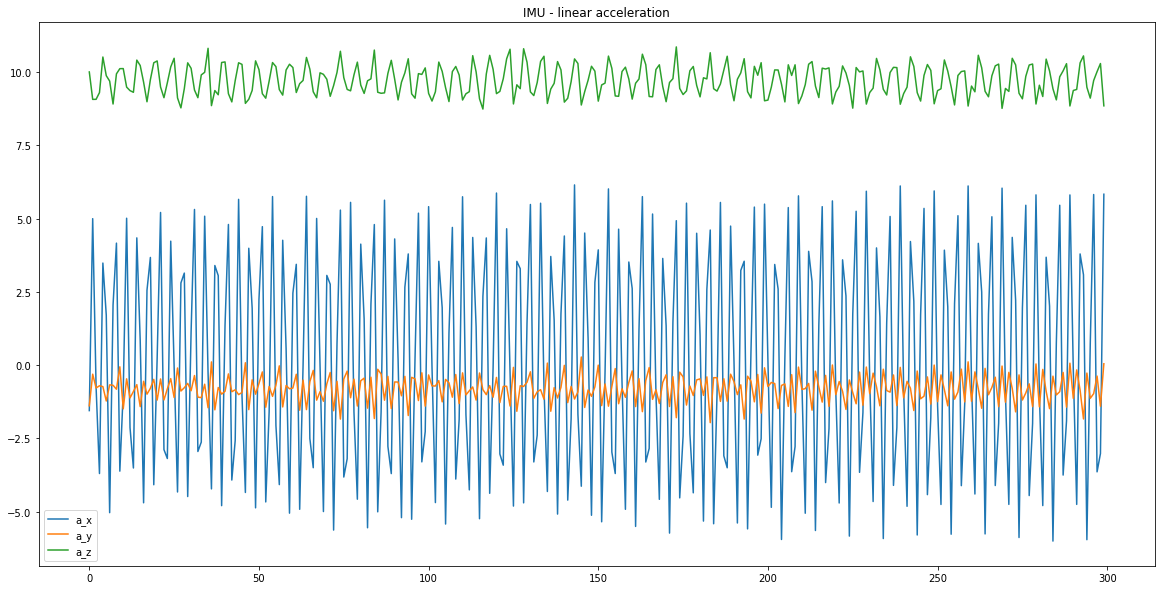

In [19]:
static_lin_acc = np.array(lin_acc)[0:m,:]
lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
print(lin_acc_imu_bias)

plt.plot(t, lin_acc[0:m,0], label="a_x")
plt.plot(t, lin_acc[0:m,1], label="a_y")
plt.plot(t, lin_acc[0:m,2], label="a_z")
plt.title("IMU - linear acceleration")
plt.legend()
plt.show()

### Extract orientation

In [20]:
theta0_z = 0.3
q_imu_list = np.empty((0,4), float)
q_prev = euler2quat(np.array([0, 0, theta0_z]))
for i in range(len(tt_imu)):
    # in the first iteration, set theta = 0
    if i==0:
        q_next = euler2quat(np.array([0, 0, theta0_z]))
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_imu[i] - tt_imu[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
         
        # find the current robot rotation matrix
        R_robot = quat2matrix(q_prev)
        R = R_b2i.T@R_robot
        
        # new orientation based on quaternion kinematics       
        w_theta = R@(ang_vel[i] - ang_vel_imu_bias)*dt
        w_norm = np.linalg.norm(w_theta)
        q_w = np.cos(w_norm/2)
        q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
        q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1)) 
        
        q_next = quat_mult(q_prev, q_omega)
            
    q_imu_list = np.append(q_imu_list, q_next.T, axis=0)
        
    q_prev = q_next

In [21]:
theta_imu_list = np.empty((0,3), float)
for x in q_imu_list:
    th = quat2euler(x)
    theta_imu_list = np.append(theta_imu_list, th.T, axis=0)

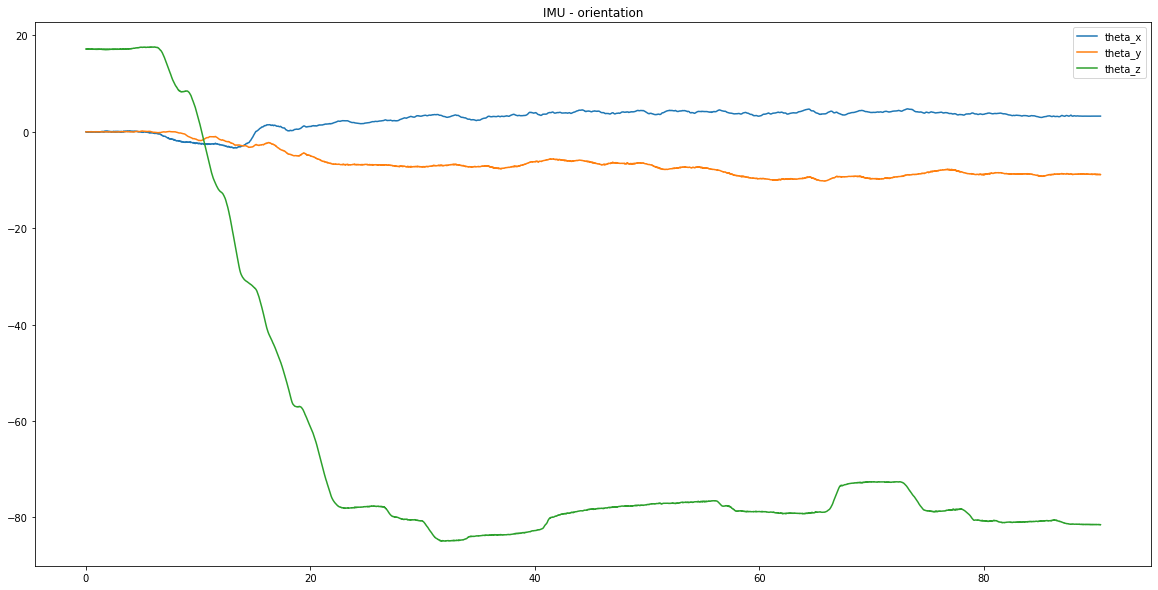

In [22]:
fig, axs = plt.subplots()

axs.plot(tt_imu, np.rad2deg(theta_imu_list[:,0]), label="theta_x")
axs.plot(tt_imu, np.rad2deg(theta_imu_list[:,1]), label="theta_y")
axs.plot(tt_imu, np.rad2deg(theta_imu_list[:,2]), label="theta_z")

plt.title("IMU - orientation")
plt.legend()
plt.show()

## GPS

### Load GPS data

In [23]:
lines = []
with open('gps.txt') as f:
    lines = f.readlines()

In [24]:
lattitude = []
longitude = []
altitude = []
sec_gps = []
nsec_gps = []
count = 0
for line in lines:
    count += 1
    if line[4:7] == "sec":
        sec_gps.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_gps.append(int(line[13:-1]))
    elif line[0:3] == "lat":
        lattitude.append(float(line[10:-1]))
    elif line[0:3] == "lon":
        longitude.append(float(line[11:-1]))
    elif line[0:3] == "alt":
        altitude.append(float(line[10:-1]))

In [25]:
temp = [i*1e-9 for i in nsec_gps]
t_gps = [sum(x) for x in zip(sec_gps, temp)]
tt_gps = np.array([x-t_gps[0] for x in t_gps])

In [26]:
lat_0 = lattitude[0]
lon_0 = longitude[0]
alt_0 = altitude[0]

x_gps = []
y_gps = []
z_gps = []
for i in range(len(lattitude)):
    # get [east, noth, up] w.r.t. an origin and assume it is [y, x, z]
    x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
    # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"
    x_gps.append(x_ + gps_off[0])
    y_gps.append(y_ + gps_off[1])
    z_gps.append(z_ + gps_off[2])

x_gps = np.array(x_gps)
y_gps = np.array(y_gps)
z_gps = np.array(z_gps)

In [27]:
vx_gps = []
vy_gps = []
vz_gps = []
for i in range(len(tt_gps)):

    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        vx, vy, vz = 0, 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps[i] - tt_gps[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")

        # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
        vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
        vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt
        vz = (z_gps.flatten()[i] - z_gps.flatten()[i-1])/dt
        
    vx_gps.append(vx)
    vy_gps.append(vy)
    vz_gps.append(vz)

vx_gps = np.array(vx_gps)
vy_gps = np.array(vy_gps)
vz_gps = np.array(vz_gps)

In [28]:
ax_gps = []
ay_gps = []
az_gps = []
for i in range(len(tt_gps)):

    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        ax, ay, az = 0, 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps[i] - tt_gps[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")

        # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
        ax = (vx_gps.flatten()[i] - vx_gps.flatten()[i-1])/dt
        ay = (vy_gps.flatten()[i] - vy_gps.flatten()[i-1])/dt
        az = (vz_gps.flatten()[i] - vz_gps.flatten()[i-1])/dt
        
    ax_gps.append(ax)
    ay_gps.append(ay)
    az_gps.append(az)

ax_gps = np.array(ax_gps)
ay_gps = np.array(ay_gps)
az_gps = np.array(az_gps)

### GPS variance and trajectory plots

[-0.0096609   0.01762649  2.13443333]


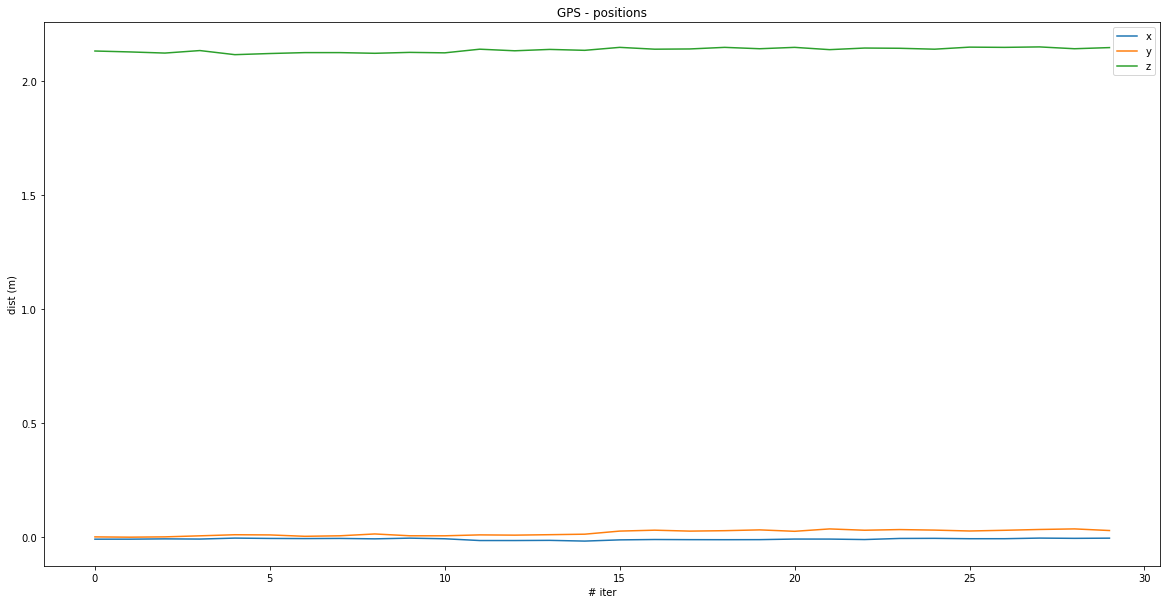

In [29]:
m = 30
t = np.arange(m)
gps_bias = np.array([np.mean(x_gps[0:m]), np.mean(y_gps[0:m]), np.mean(z_gps[0:m])])
print(gps_bias)

plt.plot(t, x_gps[0:m], label="x")
plt.plot(t, y_gps[0:m], label="y")
plt.plot(t, z_gps[0:m], label="z")
plt.title("GPS - positions")
plt.ylabel("dist (m)")
plt.xlabel("# iter")
plt.legend()
plt.show()

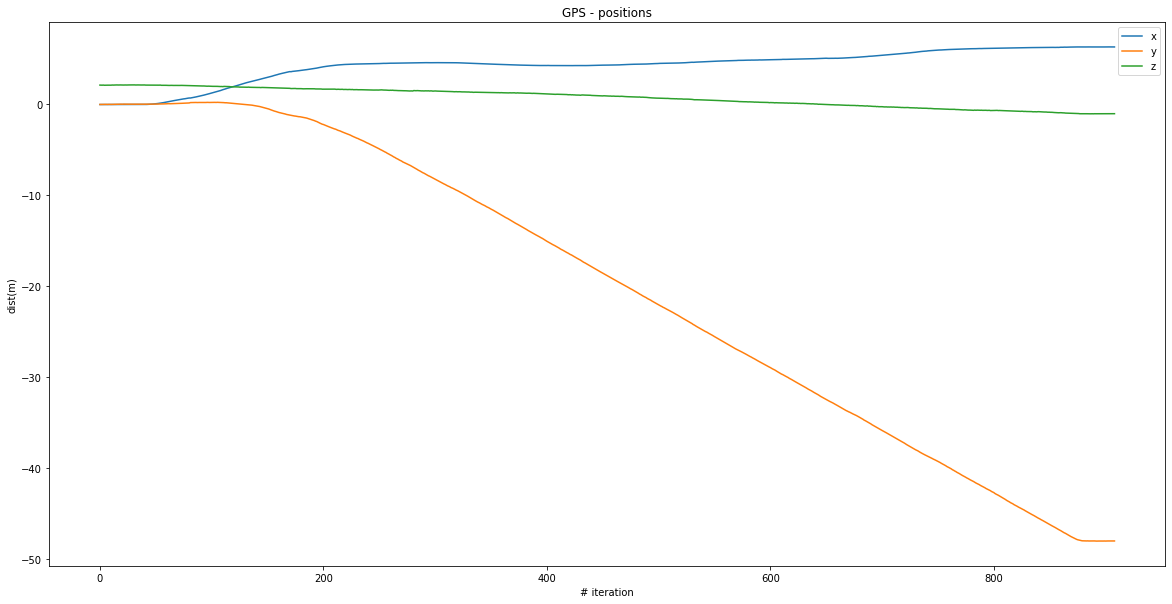

In [30]:
plt.plot(x_gps, label="x")
plt.plot(y_gps, label="y")
plt.plot(z_gps, label="z")
plt.title("GPS - positions")
plt.ylabel("dist(m)")
plt.xlabel("# iteration")
plt.legend()
plt.show()

# IMU sensor fusion

Following "Error State Extended Kalman Filter Multi-Sensor Fusion for
Unmanned Aerial Vehicle Localization in GPS and Magnetometer
Denied Indoor Environments" by Lovro M. et al.

## Functions

### Nominal state - large signal : IMU

In [31]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:3]
    v_prev = x_prev[3:6]
    q_prev = x_prev[6:10]
    a_b = x_prev[10:13]
    omega_b = x_prev[13:16]
    g = x_prev[16:19]
    p_i = x_prev[19:22]
    q_i = x_prev[22:26]
    # find the current robot rotation matrix
    R_robot = quat2matrix(q_prev)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T@R_robot
    
    # angular velocity
#     w_theta = R_robot@(R_b2i.T@(ang_vel[i] - ang_vel_imu_bias))*dt
    w_theta = R@(omega_imu - omega_b)*dt
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))  

    # apply dynamics to position, velocity and orientation
    p = p_prev + v_prev*dt + 0.5*(R @ (a_imu-a_b) + g)*(dt**2)
    v = v_prev + (R @ (a_imu - a_b) + g)*dt
    
    q = quat_mult(q_prev, q_omega)    
    
    # the nominal state
    x_out = np.vstack((p, v, q, a_b, omega_b, g, p_i, q_i))
    
    return x_out

## Loop

In [32]:
# global varialbles - mostly covariance matrices

# gravity vector
g = np.array([0, 0, -GRAV]).reshape((3,1))

In [33]:
# step 1. initialize state and covariance for the very first iteration
# nominal and error state
p0 = np.array([0, 0, 0]).reshape(3,1)
v0 = np.array([0, 0, 0]).reshape(3,1)
q0 = euler2quat(np.array([0, 0, theta0_z]))
a_b0 = lin_acc_imu_bias.reshape(3,1)
omega_b0 = ang_vel_imu_bias.reshape(3,1)
g0 = np.array([0, 0, -GRAV]).reshape(3,1)
pi0 = gps_off
qi0 = np.array([1, 0, 0, 0]).reshape(4,1)
x = np.vstack([p0, v0, q0, a_b0, omega_b0, g0, pi0, qi0])
dx = np.zeros((24,1))

# initialize time
t_prev = 0
t = 0
dt = 0

# counter for IMU sample
i = 0

# initialize empty lists to keep history of state variables
x_list = np.empty((0,26), float)
t_list = np.empty((0,1), float)

# main loop (predictions : IMU, measurements : GPS)
while True:
    print("Iteration: #", i)
    # print("IMU signal...")
    # set time
    if i!=0:
        dt = tt_imu[i] - tt_imu[i-1]
    
        # get imu readings (3x1)
        a_imu = np.array(lin_acc[i]).reshape((3,1))
        omega_imu = np.array(ang_vel[i]).reshape((3,1))

        # step 2. nominal state kinematics
        x = nominal_state(dt, x, a_imu, omega_imu)
           
    # save state values and state covariance
    x_list = np.append(x_list, x.T, axis=0) 
    t_list = np.append(t_list, tt_imu[i])
    
    # early stop for debug
    i+=1
                
    # stop when we have finished all our input readings
    if i >= len(tt_imu):
        break


print("Finito!")

Iteration: # 0
Iteration: # 1
Iteration: # 2
Iteration: # 3
Iteration: # 4
Iteration: # 5
Iteration: # 6
Iteration: # 7
Iteration: # 8
Iteration: # 9
Iteration: # 10
Iteration: # 11
Iteration: # 12
Iteration: # 13
Iteration: # 14
Iteration: # 15
Iteration: # 16
Iteration: # 17
Iteration: # 18
Iteration: # 19
Iteration: # 20
Iteration: # 21
Iteration: # 22
Iteration: # 23
Iteration: # 24
Iteration: # 25
Iteration: # 26
Iteration: # 27
Iteration: # 28
Iteration: # 29
Iteration: # 30
Iteration: # 31
Iteration: # 32
Iteration: # 33
Iteration: # 34
Iteration: # 35
Iteration: # 36
Iteration: # 37
Iteration: # 38
Iteration: # 39
Iteration: # 40
Iteration: # 41
Iteration: # 42
Iteration: # 43
Iteration: # 44
Iteration: # 45
Iteration: # 46
Iteration: # 47
Iteration: # 48
Iteration: # 49
Iteration: # 50
Iteration: # 51
Iteration: # 52
Iteration: # 53
Iteration: # 54
Iteration: # 55
Iteration: # 56
Iteration: # 57
Iteration: # 58
Iteration: # 59
Iteration: # 60
Iteration: # 61
Iteration: # 62
It

Iteration: # 789
Iteration: # 790
Iteration: # 791
Iteration: # 792
Iteration: # 793
Iteration: # 794
Iteration: # 795
Iteration: # 796
Iteration: # 797
Iteration: # 798
Iteration: # 799
Iteration: # 800
Iteration: # 801
Iteration: # 802
Iteration: # 803
Iteration: # 804
Iteration: # 805
Iteration: # 806
Iteration: # 807
Iteration: # 808
Iteration: # 809
Iteration: # 810
Iteration: # 811
Iteration: # 812
Iteration: # 813
Iteration: # 814
Iteration: # 815
Iteration: # 816
Iteration: # 817
Iteration: # 818
Iteration: # 819
Iteration: # 820
Iteration: # 821
Iteration: # 822
Iteration: # 823
Iteration: # 824
Iteration: # 825
Iteration: # 826
Iteration: # 827
Iteration: # 828
Iteration: # 829
Iteration: # 830
Iteration: # 831
Iteration: # 832
Iteration: # 833
Iteration: # 834
Iteration: # 835
Iteration: # 836
Iteration: # 837
Iteration: # 838
Iteration: # 839
Iteration: # 840
Iteration: # 841
Iteration: # 842
Iteration: # 843
Iteration: # 844
Iteration: # 845
Iteration: # 846
Iteration: # 8

Iteration: # 1591
Iteration: # 1592
Iteration: # 1593
Iteration: # 1594
Iteration: # 1595
Iteration: # 1596
Iteration: # 1597
Iteration: # 1598
Iteration: # 1599
Iteration: # 1600
Iteration: # 1601
Iteration: # 1602
Iteration: # 1603
Iteration: # 1604
Iteration: # 1605
Iteration: # 1606
Iteration: # 1607
Iteration: # 1608
Iteration: # 1609
Iteration: # 1610
Iteration: # 1611
Iteration: # 1612
Iteration: # 1613
Iteration: # 1614
Iteration: # 1615
Iteration: # 1616
Iteration: # 1617
Iteration: # 1618
Iteration: # 1619
Iteration: # 1620
Iteration: # 1621
Iteration: # 1622
Iteration: # 1623
Iteration: # 1624
Iteration: # 1625
Iteration: # 1626
Iteration: # 1627
Iteration: # 1628
Iteration: # 1629
Iteration: # 1630
Iteration: # 1631
Iteration: # 1632
Iteration: # 1633
Iteration: # 1634
Iteration: # 1635
Iteration: # 1636
Iteration: # 1637
Iteration: # 1638
Iteration: # 1639
Iteration: # 1640
Iteration: # 1641
Iteration: # 1642
Iteration: # 1643
Iteration: # 1644
Iteration: # 1645
Iteration:

Iteration: # 2468
Iteration: # 2469
Iteration: # 2470
Iteration: # 2471
Iteration: # 2472
Iteration: # 2473
Iteration: # 2474
Iteration: # 2475
Iteration: # 2476
Iteration: # 2477
Iteration: # 2478
Iteration: # 2479
Iteration: # 2480
Iteration: # 2481
Iteration: # 2482
Iteration: # 2483
Iteration: # 2484
Iteration: # 2485
Iteration: # 2486
Iteration: # 2487
Iteration: # 2488
Iteration: # 2489
Iteration: # 2490
Iteration: # 2491
Iteration: # 2492
Iteration: # 2493
Iteration: # 2494
Iteration: # 2495
Iteration: # 2496
Iteration: # 2497
Iteration: # 2498
Iteration: # 2499
Iteration: # 2500
Iteration: # 2501
Iteration: # 2502
Iteration: # 2503
Iteration: # 2504
Iteration: # 2505
Iteration: # 2506
Iteration: # 2507
Iteration: # 2508
Iteration: # 2509
Iteration: # 2510
Iteration: # 2511
Iteration: # 2512
Iteration: # 2513
Iteration: # 2514
Iteration: # 2515
Iteration: # 2516
Iteration: # 2517
Iteration: # 2518
Iteration: # 2519
Iteration: # 2520
Iteration: # 2521
Iteration: # 2522
Iteration:

Iteration: # 3339
Iteration: # 3340
Iteration: # 3341
Iteration: # 3342
Iteration: # 3343
Iteration: # 3344
Iteration: # 3345
Iteration: # 3346
Iteration: # 3347
Iteration: # 3348
Iteration: # 3349
Iteration: # 3350
Iteration: # 3351
Iteration: # 3352
Iteration: # 3353
Iteration: # 3354
Iteration: # 3355
Iteration: # 3356
Iteration: # 3357
Iteration: # 3358
Iteration: # 3359
Iteration: # 3360
Iteration: # 3361
Iteration: # 3362
Iteration: # 3363
Iteration: # 3364
Iteration: # 3365
Iteration: # 3366
Iteration: # 3367
Iteration: # 3368
Iteration: # 3369
Iteration: # 3370
Iteration: # 3371
Iteration: # 3372
Iteration: # 3373
Iteration: # 3374
Iteration: # 3375
Iteration: # 3376
Iteration: # 3377
Iteration: # 3378
Iteration: # 3379
Iteration: # 3380
Iteration: # 3381
Iteration: # 3382
Iteration: # 3383
Iteration: # 3384
Iteration: # 3385
Iteration: # 3386
Iteration: # 3387
Iteration: # 3388
Iteration: # 3389
Iteration: # 3390
Iteration: # 3391
Iteration: # 3392
Iteration: # 3393
Iteration:

Iteration: # 4121
Iteration: # 4122
Iteration: # 4123
Iteration: # 4124
Iteration: # 4125
Iteration: # 4126
Iteration: # 4127
Iteration: # 4128
Iteration: # 4129
Iteration: # 4130
Iteration: # 4131
Iteration: # 4132
Iteration: # 4133
Iteration: # 4134
Iteration: # 4135
Iteration: # 4136
Iteration: # 4137
Iteration: # 4138
Iteration: # 4139
Iteration: # 4140
Iteration: # 4141
Iteration: # 4142
Iteration: # 4143
Iteration: # 4144
Iteration: # 4145
Iteration: # 4146
Iteration: # 4147
Iteration: # 4148
Iteration: # 4149
Iteration: # 4150
Iteration: # 4151
Iteration: # 4152
Iteration: # 4153
Iteration: # 4154
Iteration: # 4155
Iteration: # 4156
Iteration: # 4157
Iteration: # 4158
Iteration: # 4159
Iteration: # 4160
Iteration: # 4161
Iteration: # 4162
Iteration: # 4163
Iteration: # 4164
Iteration: # 4165
Iteration: # 4166
Iteration: # 4167
Iteration: # 4168
Iteration: # 4169
Iteration: # 4170
Iteration: # 4171
Iteration: # 4172
Iteration: # 4173
Iteration: # 4174
Iteration: # 4175
Iteration:

Iteration: # 4908
Iteration: # 4909
Iteration: # 4910
Iteration: # 4911
Iteration: # 4912
Iteration: # 4913
Iteration: # 4914
Iteration: # 4915
Iteration: # 4916
Iteration: # 4917
Iteration: # 4918
Iteration: # 4919
Iteration: # 4920
Iteration: # 4921
Iteration: # 4922
Iteration: # 4923
Iteration: # 4924
Iteration: # 4925
Iteration: # 4926
Iteration: # 4927
Iteration: # 4928
Iteration: # 4929
Iteration: # 4930
Iteration: # 4931
Iteration: # 4932
Iteration: # 4933
Iteration: # 4934
Iteration: # 4935
Iteration: # 4936
Iteration: # 4937
Iteration: # 4938
Iteration: # 4939
Iteration: # 4940
Iteration: # 4941
Iteration: # 4942
Iteration: # 4943
Iteration: # 4944
Iteration: # 4945
Iteration: # 4946
Iteration: # 4947
Iteration: # 4948
Iteration: # 4949
Iteration: # 4950
Iteration: # 4951
Iteration: # 4952
Iteration: # 4953
Iteration: # 4954
Iteration: # 4955
Iteration: # 4956
Iteration: # 4957
Iteration: # 4958
Iteration: # 4959
Iteration: # 4960
Iteration: # 4961
Iteration: # 4962
Iteration:

Iteration: # 5566
Iteration: # 5567
Iteration: # 5568
Iteration: # 5569
Iteration: # 5570
Iteration: # 5571
Iteration: # 5572
Iteration: # 5573
Iteration: # 5574
Iteration: # 5575
Iteration: # 5576
Iteration: # 5577
Iteration: # 5578
Iteration: # 5579
Iteration: # 5580
Iteration: # 5581
Iteration: # 5582
Iteration: # 5583
Iteration: # 5584
Iteration: # 5585
Iteration: # 5586
Iteration: # 5587
Iteration: # 5588
Iteration: # 5589
Iteration: # 5590
Iteration: # 5591
Iteration: # 5592
Iteration: # 5593
Iteration: # 5594
Iteration: # 5595
Iteration: # 5596
Iteration: # 5597
Iteration: # 5598
Iteration: # 5599
Iteration: # 5600
Iteration: # 5601
Iteration: # 5602
Iteration: # 5603
Iteration: # 5604
Iteration: # 5605
Iteration: # 5606
Iteration: # 5607
Iteration: # 5608
Iteration: # 5609
Iteration: # 5610
Iteration: # 5611
Iteration: # 5612
Iteration: # 5613
Iteration: # 5614
Iteration: # 5615
Iteration: # 5616
Iteration: # 5617
Iteration: # 5618
Iteration: # 5619
Iteration: # 5620
Iteration:

Iteration: # 6279
Iteration: # 6280
Iteration: # 6281
Iteration: # 6282
Iteration: # 6283
Iteration: # 6284
Iteration: # 6285
Iteration: # 6286
Iteration: # 6287
Iteration: # 6288
Iteration: # 6289
Iteration: # 6290
Iteration: # 6291
Iteration: # 6292
Iteration: # 6293
Iteration: # 6294
Iteration: # 6295
Iteration: # 6296
Iteration: # 6297
Iteration: # 6298
Iteration: # 6299
Iteration: # 6300
Iteration: # 6301
Iteration: # 6302
Iteration: # 6303
Iteration: # 6304
Iteration: # 6305
Iteration: # 6306
Iteration: # 6307
Iteration: # 6308
Iteration: # 6309
Iteration: # 6310
Iteration: # 6311
Iteration: # 6312
Iteration: # 6313
Iteration: # 6314
Iteration: # 6315
Iteration: # 6316
Iteration: # 6317
Iteration: # 6318
Iteration: # 6319
Iteration: # 6320
Iteration: # 6321
Iteration: # 6322
Iteration: # 6323
Iteration: # 6324
Iteration: # 6325
Iteration: # 6326
Iteration: # 6327
Iteration: # 6328
Iteration: # 6329
Iteration: # 6330
Iteration: # 6331
Iteration: # 6332
Iteration: # 6333
Iteration:

Iteration: # 6892
Iteration: # 6893
Iteration: # 6894
Iteration: # 6895
Iteration: # 6896
Iteration: # 6897
Iteration: # 6898
Iteration: # 6899
Iteration: # 6900
Iteration: # 6901
Iteration: # 6902
Iteration: # 6903
Iteration: # 6904
Iteration: # 6905
Iteration: # 6906
Iteration: # 6907
Iteration: # 6908
Iteration: # 6909
Iteration: # 6910
Iteration: # 6911
Iteration: # 6912
Iteration: # 6913
Iteration: # 6914
Iteration: # 6915
Iteration: # 6916
Iteration: # 6917
Iteration: # 6918
Iteration: # 6919
Iteration: # 6920
Iteration: # 6921
Iteration: # 6922
Iteration: # 6923
Iteration: # 6924
Iteration: # 6925
Iteration: # 6926
Iteration: # 6927
Iteration: # 6928
Iteration: # 6929
Iteration: # 6930
Iteration: # 6931
Iteration: # 6932
Iteration: # 6933
Iteration: # 6934
Iteration: # 6935
Iteration: # 6936
Iteration: # 6937
Iteration: # 6938
Iteration: # 6939
Iteration: # 6940
Iteration: # 6941
Iteration: # 6942
Iteration: # 6943
Iteration: # 6944
Iteration: # 6945
Iteration: # 6946
Iteration:

Iteration: # 7437
Iteration: # 7438
Iteration: # 7439
Iteration: # 7440
Iteration: # 7441
Iteration: # 7442
Iteration: # 7443
Iteration: # 7444
Iteration: # 7445
Iteration: # 7446
Iteration: # 7447
Iteration: # 7448
Iteration: # 7449
Iteration: # 7450
Iteration: # 7451
Iteration: # 7452
Iteration: # 7453
Iteration: # 7454
Iteration: # 7455
Iteration: # 7456
Iteration: # 7457
Iteration: # 7458
Iteration: # 7459
Iteration: # 7460
Iteration: # 7461
Iteration: # 7462
Iteration: # 7463
Iteration: # 7464
Iteration: # 7465
Iteration: # 7466
Iteration: # 7467
Iteration: # 7468
Iteration: # 7469
Iteration: # 7470
Iteration: # 7471
Iteration: # 7472
Iteration: # 7473
Iteration: # 7474
Iteration: # 7475
Iteration: # 7476
Iteration: # 7477
Iteration: # 7478
Iteration: # 7479
Iteration: # 7480
Iteration: # 7481
Iteration: # 7482
Iteration: # 7483
Iteration: # 7484
Iteration: # 7485
Iteration: # 7486
Iteration: # 7487
Iteration: # 7488
Iteration: # 7489
Iteration: # 7490
Iteration: # 7491
Iteration:

Iteration: # 7946
Iteration: # 7947
Iteration: # 7948
Iteration: # 7949
Iteration: # 7950
Iteration: # 7951
Iteration: # 7952
Iteration: # 7953
Iteration: # 7954
Iteration: # 7955
Iteration: # 7956
Iteration: # 7957
Iteration: # 7958
Iteration: # 7959
Iteration: # 7960
Iteration: # 7961
Iteration: # 7962
Iteration: # 7963
Iteration: # 7964
Iteration: # 7965
Iteration: # 7966
Iteration: # 7967
Iteration: # 7968
Iteration: # 7969
Iteration: # 7970
Iteration: # 7971
Iteration: # 7972
Iteration: # 7973
Iteration: # 7974
Iteration: # 7975
Iteration: # 7976
Iteration: # 7977
Iteration: # 7978
Iteration: # 7979
Iteration: # 7980
Iteration: # 7981
Iteration: # 7982
Iteration: # 7983
Iteration: # 7984
Iteration: # 7985
Iteration: # 7986
Iteration: # 7987
Iteration: # 7988
Iteration: # 7989
Iteration: # 7990
Iteration: # 7991
Iteration: # 7992
Iteration: # 7993
Iteration: # 7994
Iteration: # 7995
Iteration: # 7996
Iteration: # 7997
Iteration: # 7998
Iteration: # 7999
Iteration: # 8000
Iteration:

Iteration: # 8449
Iteration: # 8450
Iteration: # 8451
Iteration: # 8452
Iteration: # 8453
Iteration: # 8454
Iteration: # 8455
Iteration: # 8456
Iteration: # 8457
Iteration: # 8458
Iteration: # 8459
Iteration: # 8460
Iteration: # 8461
Iteration: # 8462
Iteration: # 8463
Iteration: # 8464
Iteration: # 8465
Iteration: # 8466
Iteration: # 8467
Iteration: # 8468
Iteration: # 8469
Iteration: # 8470
Iteration: # 8471
Iteration: # 8472
Iteration: # 8473
Iteration: # 8474
Iteration: # 8475
Iteration: # 8476
Iteration: # 8477
Iteration: # 8478
Iteration: # 8479
Iteration: # 8480
Iteration: # 8481
Iteration: # 8482
Iteration: # 8483
Iteration: # 8484
Iteration: # 8485
Iteration: # 8486
Iteration: # 8487
Iteration: # 8488
Iteration: # 8489
Iteration: # 8490
Iteration: # 8491
Iteration: # 8492
Iteration: # 8493
Iteration: # 8494
Iteration: # 8495
Iteration: # 8496
Iteration: # 8497
Iteration: # 8498
Iteration: # 8499
Iteration: # 8500
Iteration: # 8501
Iteration: # 8502
Iteration: # 8503
Iteration:

Iteration: # 8964
Iteration: # 8965
Iteration: # 8966
Iteration: # 8967
Iteration: # 8968
Iteration: # 8969
Iteration: # 8970
Iteration: # 8971
Iteration: # 8972
Iteration: # 8973
Iteration: # 8974
Iteration: # 8975
Iteration: # 8976
Iteration: # 8977
Iteration: # 8978
Iteration: # 8979
Iteration: # 8980
Iteration: # 8981
Iteration: # 8982
Iteration: # 8983
Iteration: # 8984
Iteration: # 8985
Iteration: # 8986
Iteration: # 8987
Iteration: # 8988
Iteration: # 8989
Iteration: # 8990
Iteration: # 8991
Iteration: # 8992
Iteration: # 8993
Iteration: # 8994
Iteration: # 8995
Iteration: # 8996
Iteration: # 8997
Iteration: # 8998
Iteration: # 8999
Iteration: # 9000
Iteration: # 9001
Iteration: # 9002
Iteration: # 9003
Iteration: # 9004
Iteration: # 9005
Iteration: # 9006
Iteration: # 9007
Iteration: # 9008
Iteration: # 9009
Iteration: # 9010
Iteration: # 9011
Iteration: # 9012
Iteration: # 9013
Iteration: # 9014
Iteration: # 9015
Iteration: # 9016
Iteration: # 9017
Iteration: # 9018
Iteration:

# Plots

## Nominal state

### Rotational movement

In [34]:
e_list = np.empty((0,3), float)
for x in x_list:
    e = quat2euler(x[6:10])
    e_list = np.append(e_list, [e.flatten()], axis=0)

#### Orientation

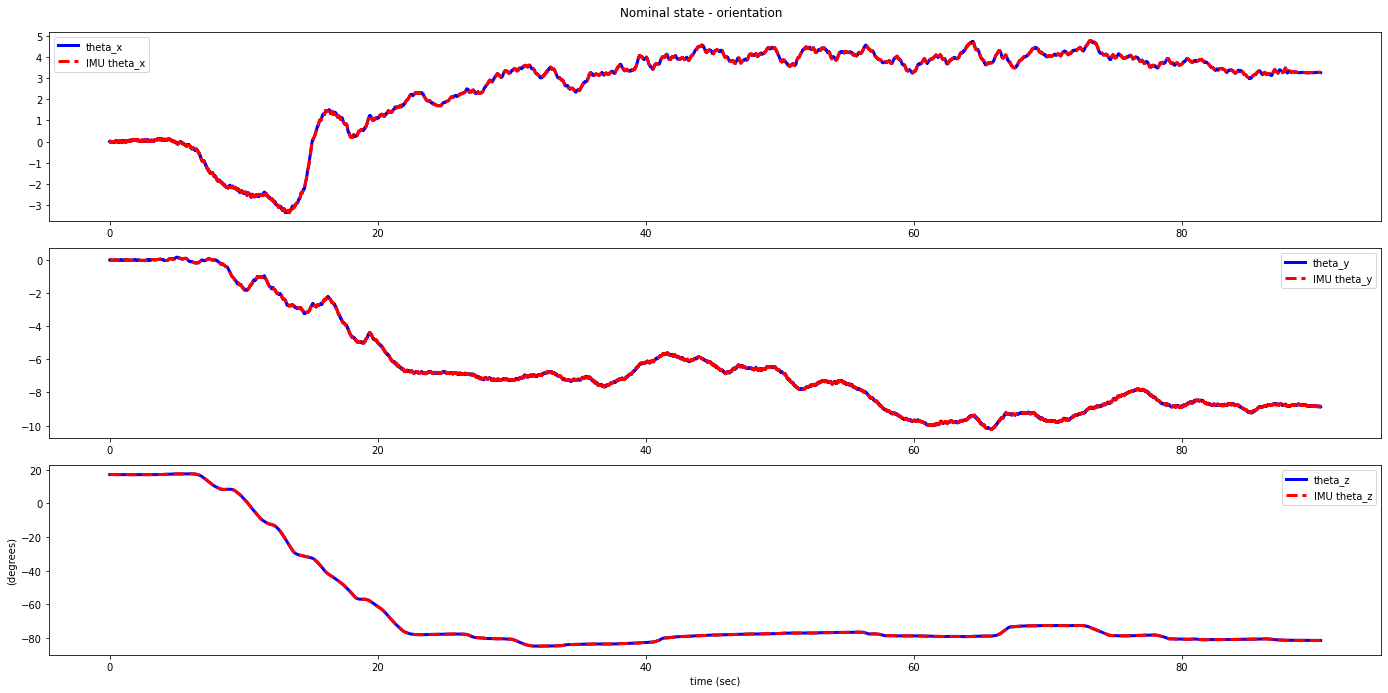

In [35]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, np.rad2deg(e_list[:,0]), 'b-', linewidth=3, label="theta_x")
axs[1].plot(t_list, np.rad2deg(e_list[:,1]), 'b-', linewidth=3, label="theta_y")
axs[2].plot(t_list, np.rad2deg(e_list[:,2]), 'b-', linewidth=3, label="theta_z")
  
axs[0].plot(tt_imu, np.rad2deg(theta_imu_list[:,0]), 'r--', linewidth=3, label="IMU theta_x")
axs[1].plot(tt_imu, np.rad2deg(theta_imu_list[:,1]), 'r--', linewidth=3, label="IMU theta_y")
axs[2].plot(tt_imu, np.rad2deg(theta_imu_list[:,2]), 'r--', linewidth=3, label="IMU theta_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(degrees)")
plt.suptitle("Nominal state - orientation")
plt.show()

#### Angular velocity

In [36]:
w_list = np.zeros((1,3))
for i in range(1, len(t_list)):
    w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])
    w_list = np.append(w_list, [w.flatten()], axis=0)
    
w1_list = np.zeros((1,3))
for i in range(1, len(t_list)):
    w1 = (theta_imu_list[i,:] - theta_imu_list[i-1, :])/(t_list[i] - t_list[i-1])
    w1_list = np.append(w1_list, [w1.flatten()], axis=0)

In [37]:
# convert IMU angular velocity to base_link frame to compare to the ESEKF results
ang_vel_rotated = np.array([R_b2i.T@x.tolist() for x in ang_vel])

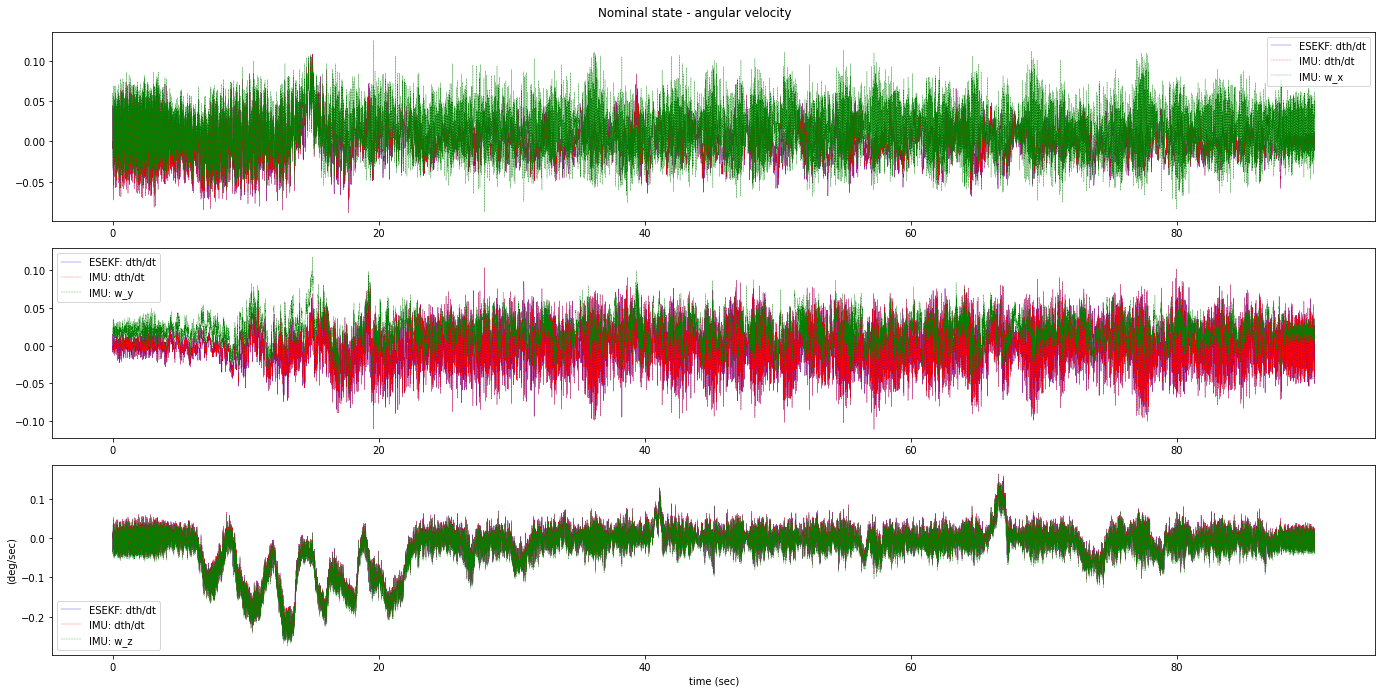

In [38]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, w_list[:,0], 'b-', linewidth=0.3, label="ESEKF: dth/dt")
axs[1].plot(t_list, w_list[:,1], 'b-', linewidth=0.3, label="ESEKF: dth/dt")
axs[2].plot(t_list, w_list[:,2], 'b-', linewidth=0.3, label="ESEKF: dth/dt")

axs[0].plot(t_list, w1_list[:,0], 'r--', linewidth=0.3, label="IMU: dth/dt")
axs[1].plot(t_list, w1_list[:,1], 'r--', linewidth=0.3, label="IMU: dth/dt")
axs[2].plot(t_list, w1_list[:,2], 'r--', linewidth=0.3, label="IMU: dth/dt")

axs[0].plot(tt_imu[0:len(x_list)], ang_vel_rotated[0:len(x_list),0], 'g--', 
            linewidth=0.3, label="IMU: w_x")
axs[1].plot(tt_imu[0:len(x_list)], ang_vel_rotated[0:len(x_list),1], 'g--', 
            linewidth=0.3, label="IMU: w_y")
axs[2].plot(tt_imu[0:len(x_list)], ang_vel_rotated[0:len(x_list),2], 'g--', 
            linewidth=0.3, label="IMU: w_z") 

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(deg/sec)")
plt.suptitle("Nominal state - angular velocity")
plt.show()

#### Angular velocity bias

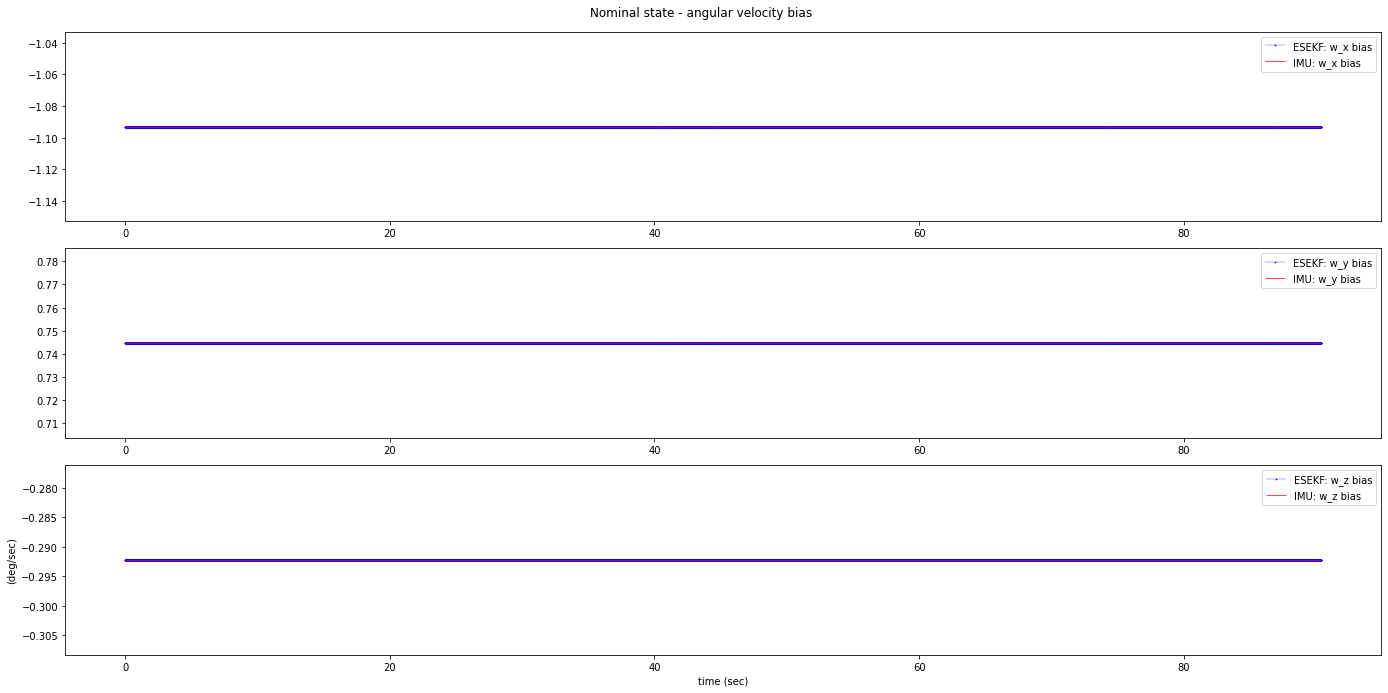

In [39]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, np.rad2deg(x_list[:,13]), 'b-o', markersize=0.7, linewidth=0.3, label="ESEKF: w_x bias")
axs[1].plot(t_list, np.rad2deg(x_list[:,14]), 'b-o', markersize=0.7, linewidth=0.3, label="ESEKF: w_y bias")
axs[2].plot(t_list, np.rad2deg(x_list[:,15]), 'b-o', markersize=0.7, linewidth=0.3, label="ESEKF: w_z bias")

axs[0].hlines(np.rad2deg(ang_vel_imu_bias)[0], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_x bias")
axs[1].hlines(np.rad2deg(ang_vel_imu_bias)[1], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_y bias")
axs[2].hlines(np.rad2deg(ang_vel_imu_bias)[2], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_z bias")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(deg/sec)")
plt.suptitle("Nominal state - angular velocity bias")
plt.show()

### Translational movement

#### Position

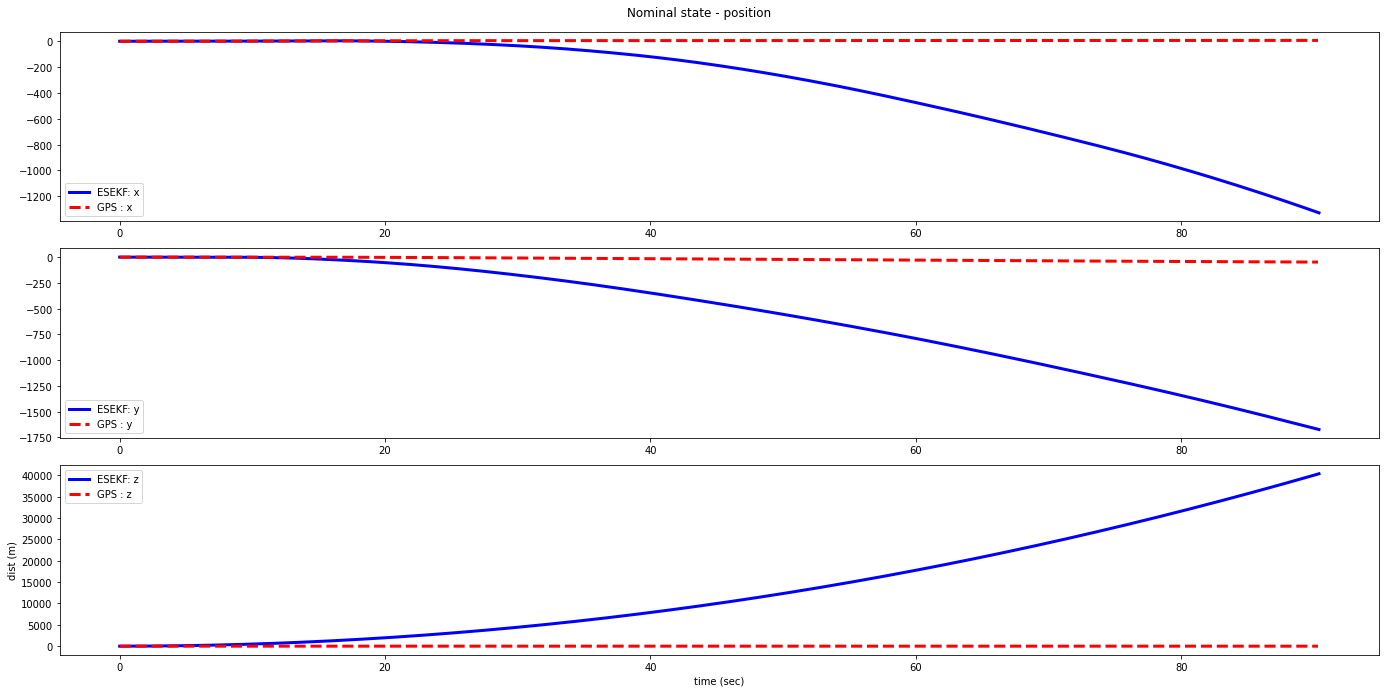

In [40]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,0], 'b-', linewidth=3, label="ESEKF: x")
axs[1].plot(t_list, x_list[:,1], 'b-', linewidth=3, label="ESEKF: y")
axs[2].plot(t_list, x_list[:,2], 'b-', linewidth=3, label="ESEKF: z")

axs[0].plot(tt_gps[0:int(len(x_list)/10)+1], x_gps[0:int(len(x_list)/10)+1]-gps_off[0], 'r--', 
            linewidth=3, label="GPS : x")
axs[1].plot(tt_gps[0:int(len(x_list)/10)+1], y_gps[0:int(len(x_list)/10)+1]-gps_off[1], 'r--', 
            linewidth=3, label="GPS : y")
axs[2].plot(tt_gps[0:int(len(x_list)/10)+1], z_gps[0:int(len(x_list)/10)+1]-gps_off[2], 'r--', 
            linewidth=3, label="GPS : z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("dist (m)")
plt.suptitle("Nominal state - position")
plt.show()

#### Velocity

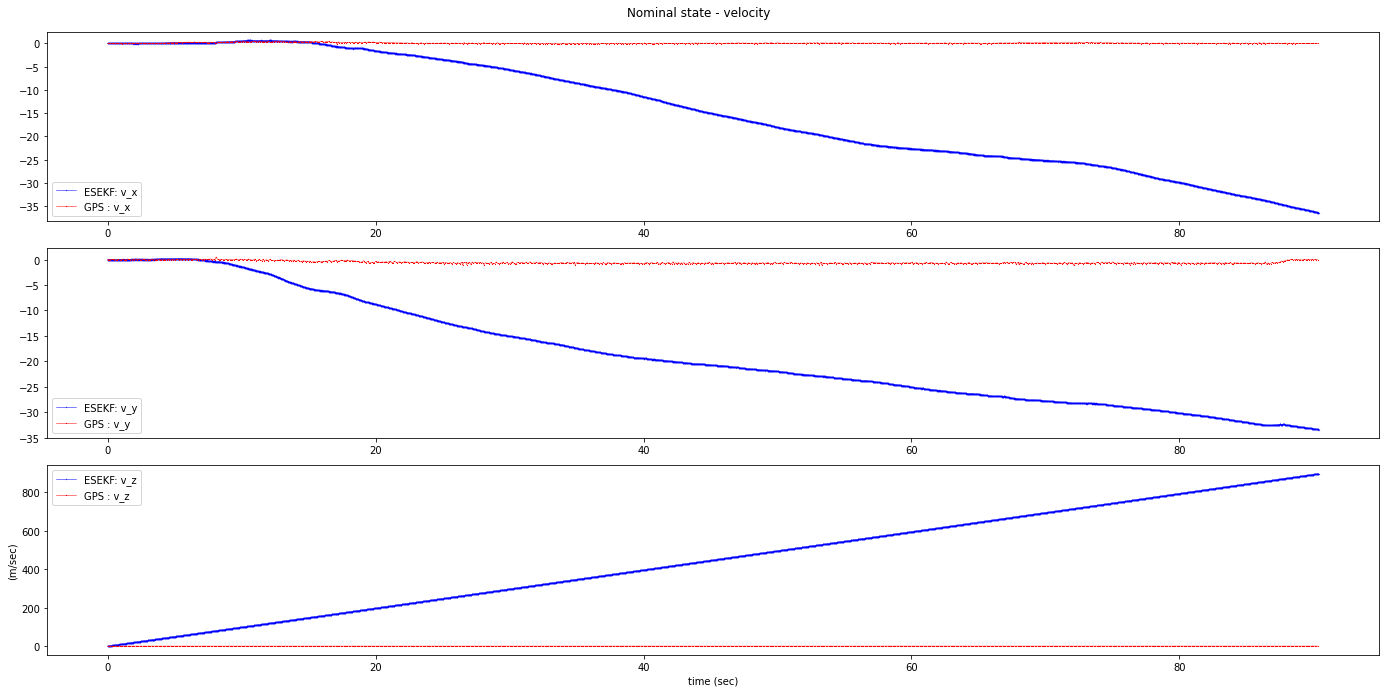

In [41]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,3], 'b-o', markersize=0.3, linewidth=0.5, label="ESEKF: v_x")
axs[1].plot(t_list, x_list[:,4], 'b-o', markersize=0.3, linewidth=0.5, label="ESEKF: v_y")
axs[2].plot(t_list, x_list[:,5], 'b-o', markersize=0.3, linewidth=0.5, label="ESEKF: v_z")

axs[0].plot(tt_gps[0:int(len(x_list)/10)+1], vx_gps[0:int(len(x_list)/10)+1], 
            'r-x', markersize=0.5, linewidth=0.5, label="GPS : v_x")
axs[1].plot(tt_gps[0:int(len(x_list)/10)+1], vy_gps[0:int(len(x_list)/10)+1], 
            'r-x', markersize=0.5, linewidth=0.5, label="GPS : v_y")
axs[2].plot(tt_gps[0:int(len(x_list)/10)+1], vz_gps[0:int(len(x_list)/10)+1], 
            'r-x', markersize=0.5, linewidth=0.5, label="GPS : v_z")
  
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(m/sec)")
plt.suptitle("Nominal state - velocity")
plt.show()

#### Acceleration

In [42]:
a_list = np.zeros((1,3))
for i in range(1, len(t_list)):
    a = (x_list[i, 3:6] - x_list[i-1, 3:6])/(t_list[i] - t_list[i-1])
    a_list = np.append(a_list, [a.flatten()], axis=0)

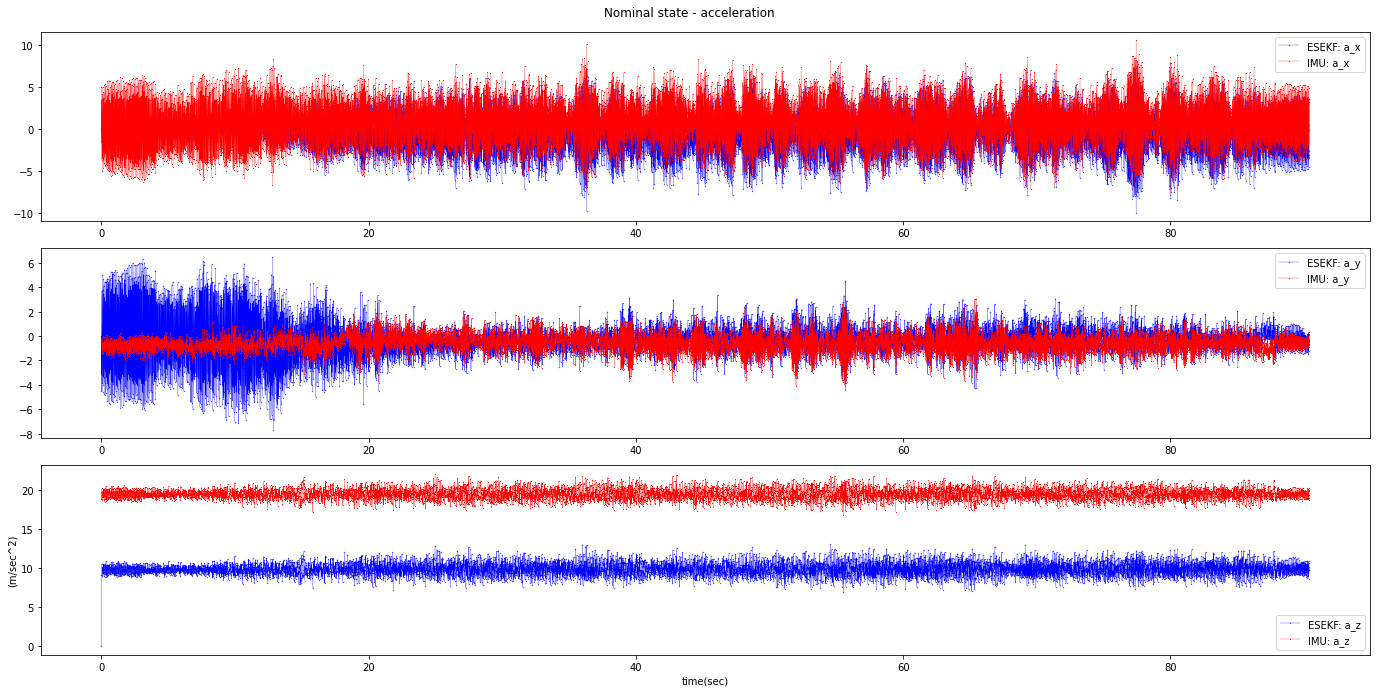

In [43]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, a_list[:,0], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_x")
axs[1].plot(t_list, a_list[:,1], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_y")
axs[2].plot(t_list, a_list[:,2], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_z")

axs[0].plot(tt_imu[0:len(x_list)], lin_acc[0:len(x_list),0], 'r-x', 
            markersize=0.3, linewidth=0.3, label="IMU: a_x")
axs[1].plot(tt_imu[0:len(x_list)], lin_acc[0:len(x_list),1], 'r-x', 
            markersize=0.3, linewidth=0.3, label="IMU: a_y")
axs[2].plot(tt_imu[0:len(x_list)], lin_acc[0:len(x_list),2]-GRAV, 'r-x', 
            markersize=0.3, linewidth=0.3, label="IMU: a_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time(sec)")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - acceleration")
plt.show()

#### Linear acceleration bias

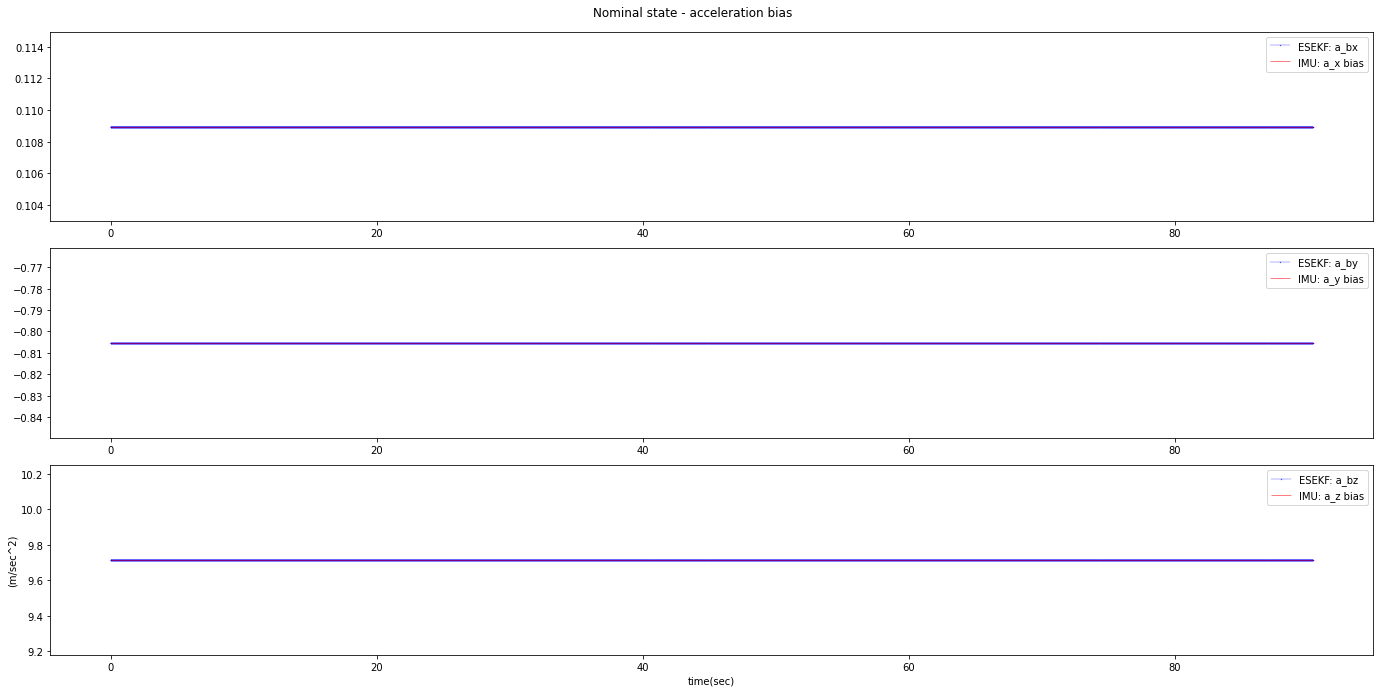

In [44]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,10], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_bx")
axs[1].plot(t_list, x_list[:,11], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_by")
axs[2].plot(t_list, x_list[:,12], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_bz")

axs[0].hlines(lin_acc_imu_bias[0], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_x bias")
axs[1].hlines(lin_acc_imu_bias[1], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_y bias")
axs[2].hlines(lin_acc_imu_bias[2], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_z bias")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time(sec)")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - acceleration bias")
plt.show()

### Gravity

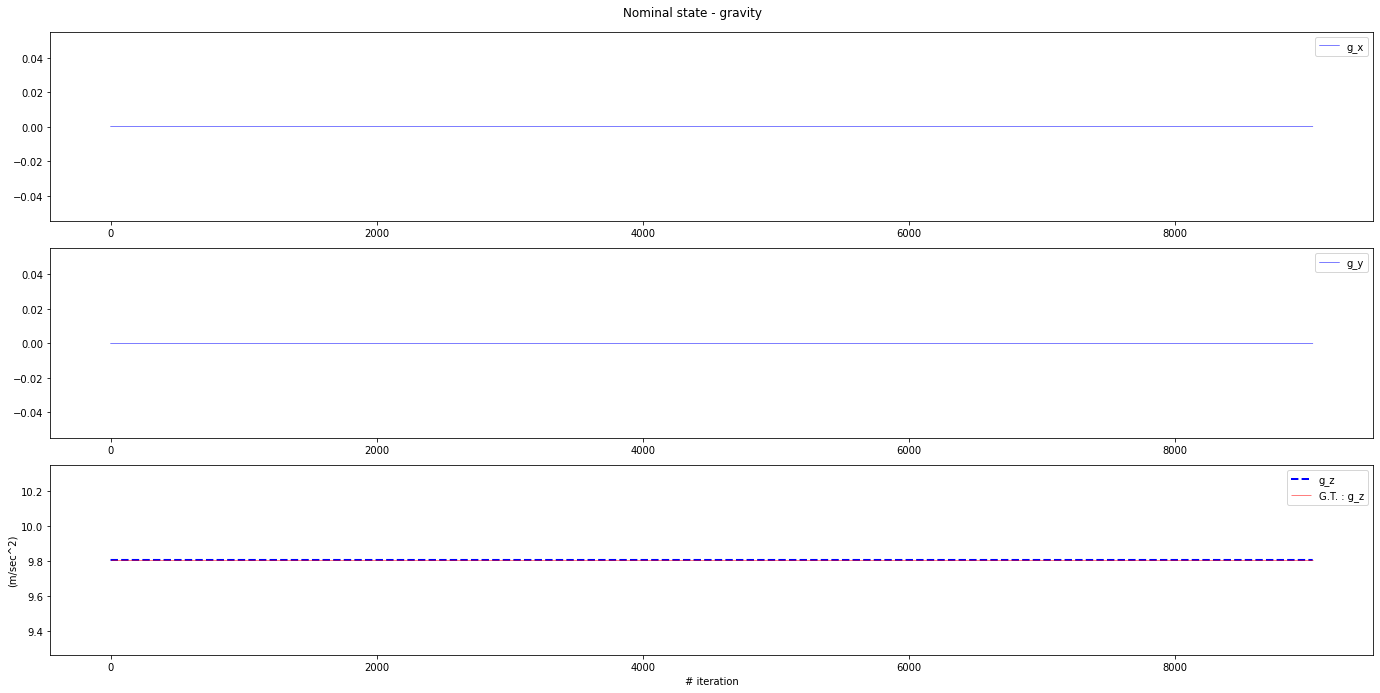

In [45]:
fig, axs = plt.subplots(3)

axs[0].plot(x_list[:,16], 'b-', markersize=0.3, linewidth=0.5, label="g_x")
axs[1].plot(x_list[:,17], 'b-', markersize=0.3, linewidth=0.5, label="g_y")
axs[2].plot(x_list[:,18], 'b--', markersize=0.3, linewidth=2, label="g_z")
axs[2].hlines(-GRAV, 0, len(x_list), 'r', linewidth=0.5, label="G.T. : g_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("# iteration")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - gravity")
plt.show()

### Extrinsic calibration

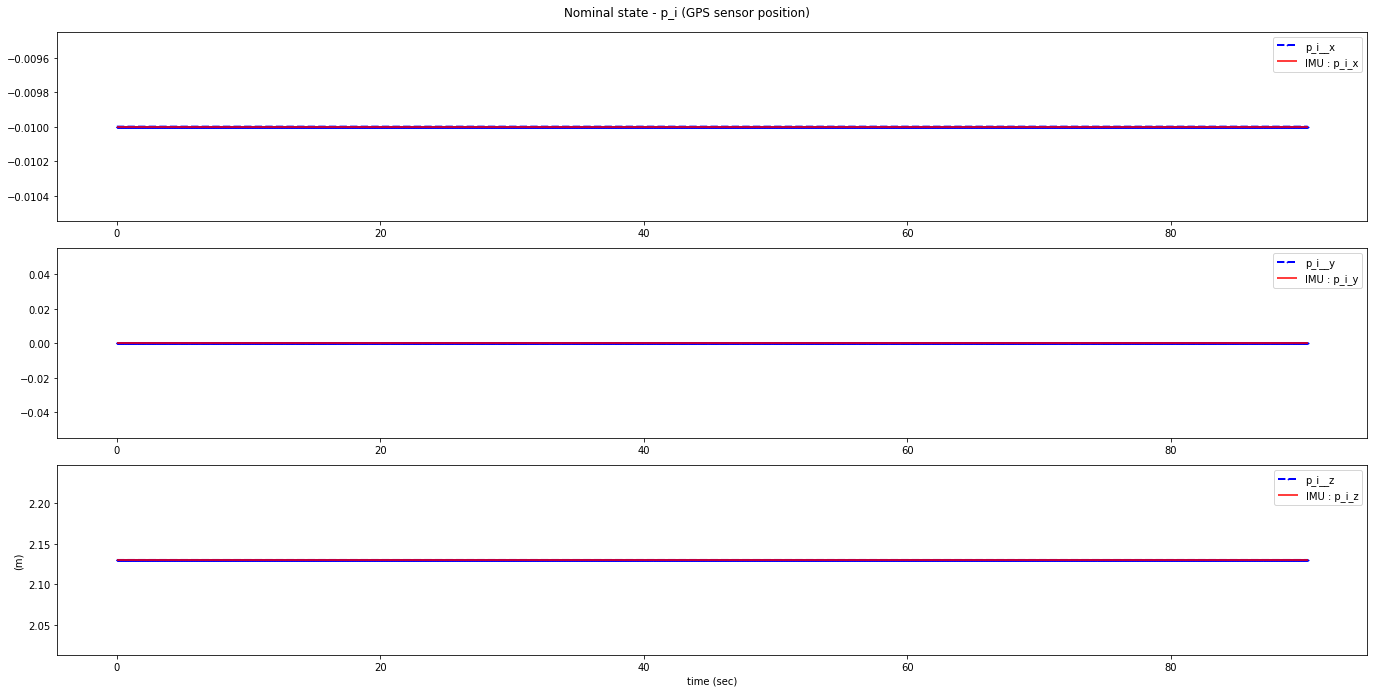

In [46]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,19], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
axs[1].plot(t_list, x_list[:,20], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
axs[2].plot(t_list, x_list[:,21], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
  
axs[0].hlines(gps_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
axs[1].hlines(gps_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
axs[2].hlines(gps_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
    
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(m)")
plt.suptitle("Nominal state - p_i (GPS sensor position)")
plt.show()

In [47]:
e_i_list = np.empty((0,3), float)
for x in x_list:
    e_i = quat2euler(x[22:26])
    e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

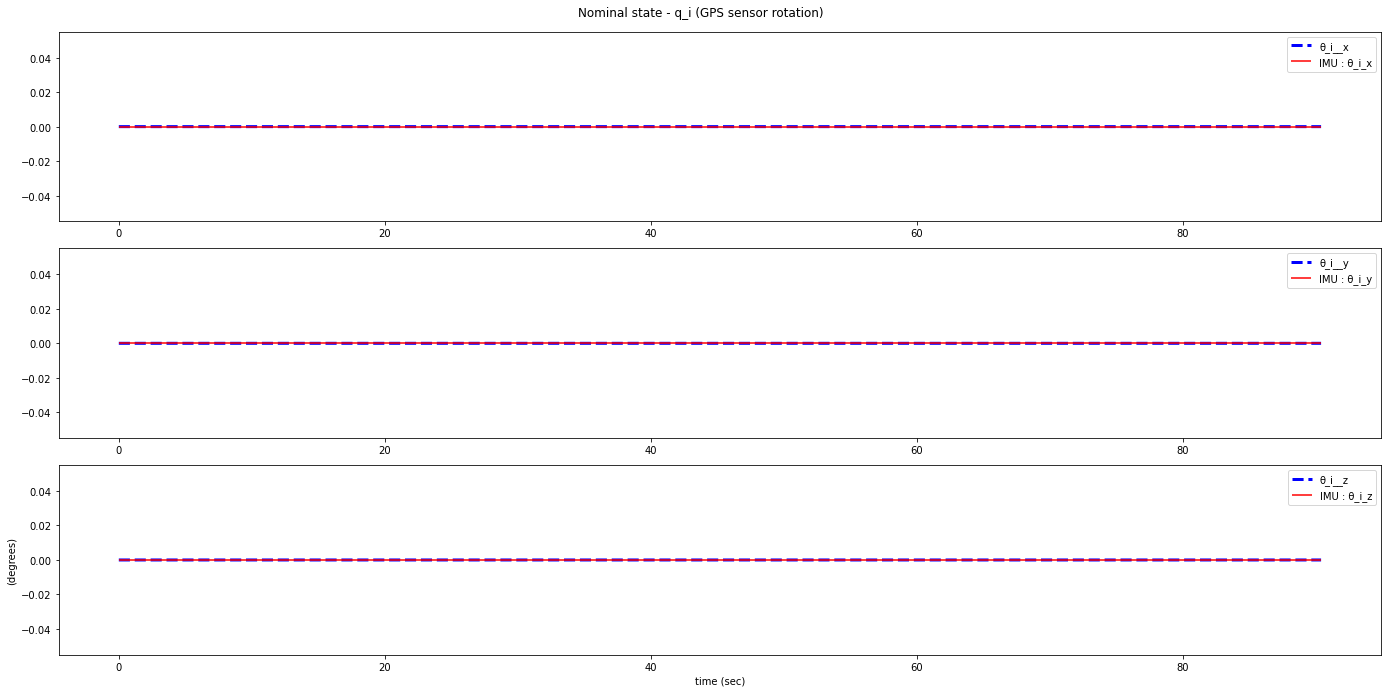

In [48]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
  
axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
            
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(degrees)")
plt.suptitle("Nominal state - q_i (GPS sensor rotation)")
plt.show()

## Trajectory in 2d

<IPython.core.display.Javascript object>


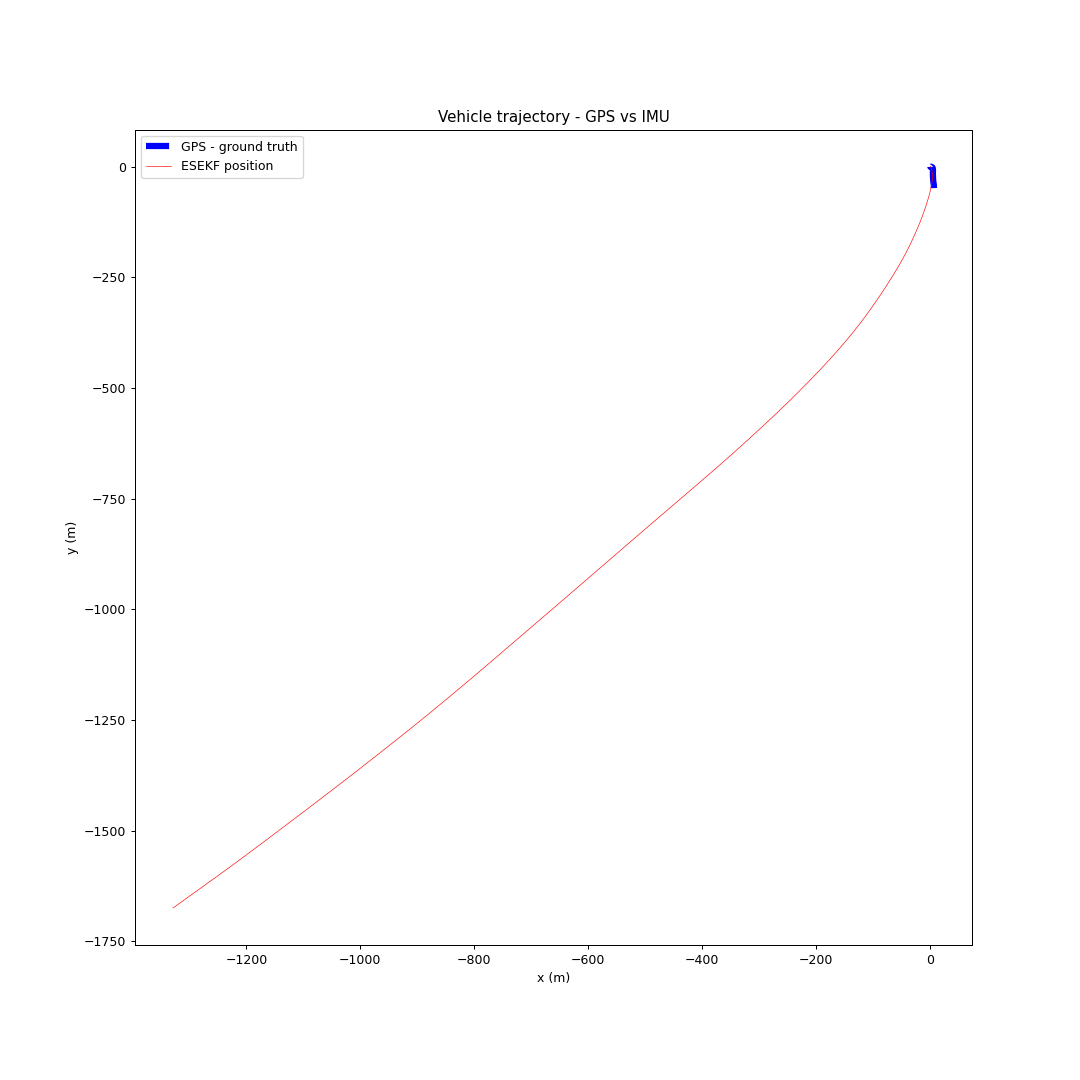

In [54]:
fig, axs = plt.subplots()

axs.plot(x_gps, y_gps, 'b--', linewidth=5, label = "GPS - ground truth")
axs.plot(x_list[:,0], x_list[:,1], 'r-', linewidth=0.5, label = "ESEKF position")

plt.title("Vehicle trajectory - GPS vs IMU")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


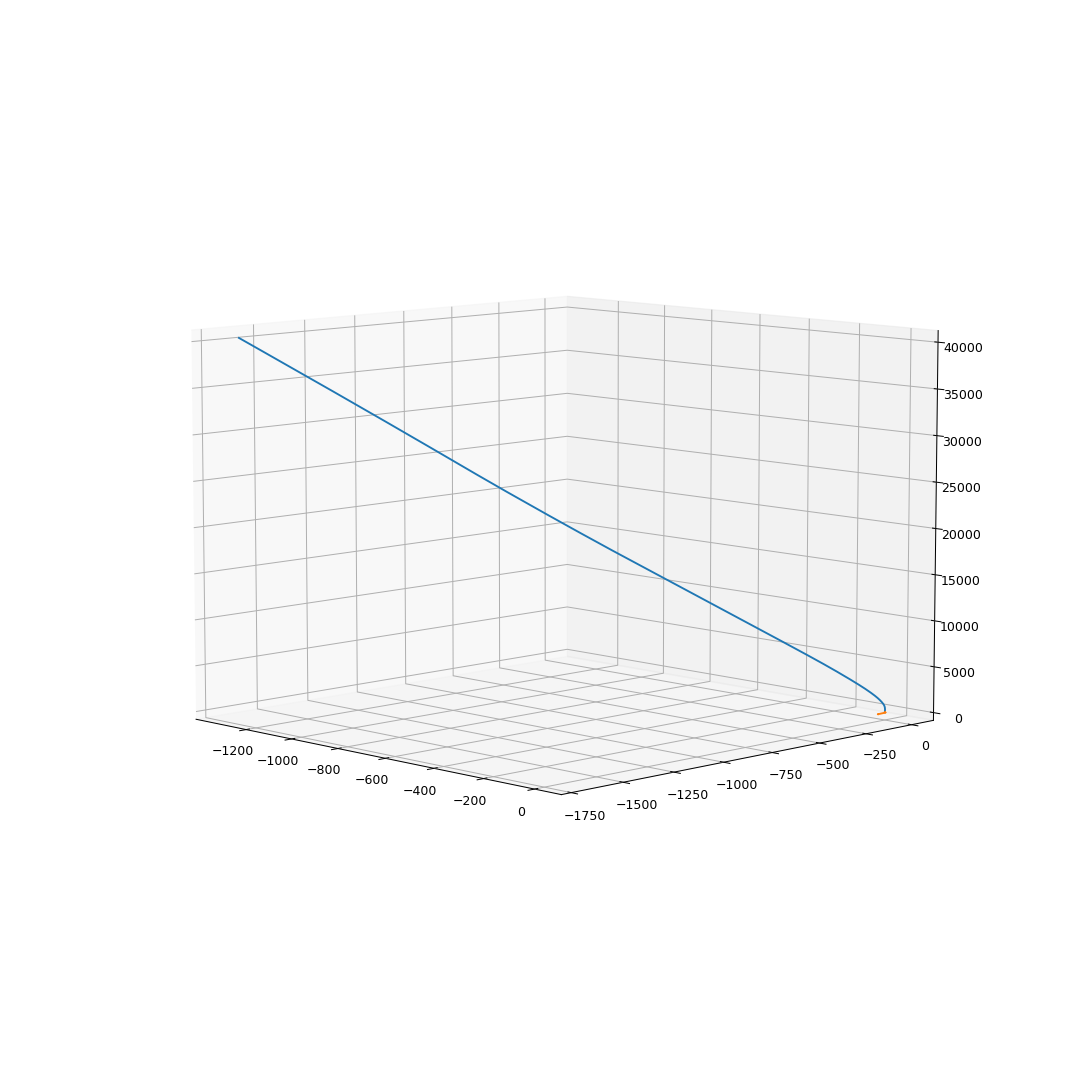

In [50]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = (12,12)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot(x_list[:,0], x_list[:,1], x_list[:,2], label="ESEKF")
ax.plot(x_gps.flatten()-gps_off[0], y_gps.flatten()-gps_off[1], z_gps.flatten()-gps_off[2], label="real")

plt.legend()
plt.show()